In [ ]:
r = requests.get('https://www.jobfeed.nl/api/v3/search?_fields=posting_id,job_title,full_text&date__range=now-2M__now-1M&_limit=10000&job_title=senior|sr|medior|junior|jr',
                 auth=('USER', 'PASSWORD'))

results = pd.DataFrame(r.json()['results'])

def determine_seniority(title):
    seniority = ''
    if re.search(r'\b(senior|sr)\b', title, re.IGNORECASE):
        seniority = 'Senior'
    elif re.search(r'\b(medior)\b', title, re.IGNORECASE):
        seniority = 'Medior'
    elif re.search(r'\b(junior|jr)\b', title, re.IGNORECASE):
        seniority = 'Junior'
    return seniority

results['seniority_level'] = results['job_title'].apply(determine_seniority)

results[['posting_id', 'job_title', 'full_text', 'seniority_level']] \
    .to_csv('data/seniority-nl.csv', index=False, header=True, quoting=csv.QUOTE_ALL)

In [1]:
import pandas as pd

df = pd.read_csv('data/seniority-nl.csv', index_col=None)

In [2]:
df.head(n=10)

,posting_id,job_title,full_text,seniority_level
0,3efed3118bb548e3b043cdfbd3fe7382,Jr. Tekenaar Verkeersmaatregelen,Jr. Tekenaar Verkeersmaatregelen (4051NL)\n\...,Junior
1,325c1388fbd140f596b163092f3ab651,DC | Senior Python developer | Tech startup | ...,DC | Senior Python developer | Tech startup ...,Senior
2,ec362644c45440028b2ce212620bddff,Fulltime Junior HR Business Partner @ JD Sports,Fulltime Junior HR Business Partner @ JD Spo...,Junior
3,ec8aad3a8af74e58a2d67a657e1fc228,Junior Elektronicus (richting elektronica),Junior Elektronicus (richting elektronica) m...,Junior
4,491e38a5d26a4bacbeadf5fbdecd80c1,Junior Belastingadviseur,Terug naar resultaten\n * Vorige\n * Volge...,Junior
5,a50b54a92fc740cfa6b3e76aebb5ce80,Talentvolle Junior Engineers Gezocht,Talentvolle Junior Engineers Gezocht (1849NL...,Junior
6,0580a19a67b949aa99ce9e18ef4b6c6e,Senior plus jurist,Senior plus jurist\n\n * Je hebt minimaal d...,Senior
7,c0322942df1546e98e2ea7e3c2ac90a7,Junior Sales,Junior Sales\n\n Dinsdag 14 mei 2019\n\n U...,Junior
8,3eda49fbe02a4cd8a522caee4c572a3b,Junior Stylist 1,Junior Stylist 1\n\n Locatie: AMI Kappers D...,Junior
9,a2a4ed131d0740b389aed302b5372e1c,Junior Quantitative Analyst - Quants Analyst -...,Junior Quantitative Analyst/Quants Analyst -...,Junior


In [3]:
df.shape

(12820, 4)

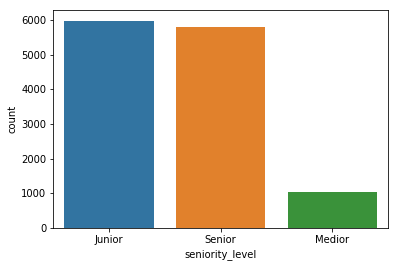

In [6]:
%matplotlib inline

import seaborn as sns

sns.countplot(x=df['seniority_level'])

In [7]:
from gensim.parsing.preprocessing import preprocess_string, RE_TAGS, strip_punctuation, stem_text, \
    strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short, strip_non_alphanum
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler
from sklearn.decomposition import TruncatedSVD
from unicodedata import normalize

my_filters = [
    lambda x: x.lower(), strip_punctuation, strip_non_alphanum,
    strip_multiple_whitespaces, remove_stopwords
]

def my_tokenizer(s):
    return preprocess_string(s, filters=my_filters)

stop_words = ['junior', 'medior', 'senior']
    
vect = CountVectorizer(min_df=400, max_df=0.2, analyzer='word', tokenizer=my_tokenizer, ngram_range=(1,2),
                       stop_words=stop_words)

le = LabelEncoder()

X = vect.fit_transform(df['full_text'])
y = le.fit_transform(df['seniority_level'])

In [8]:
X.shape

(12820, 2039)

In [9]:
y.shape

(12820,)

In [10]:
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC

classifiers = [
    MultinomialNB(),
    LogisticRegression(solver='lbfgs', max_iter=500, multi_class='multinomial'),
    LogisticRegression(solver='lbfgs', max_iter=500, multi_class='multinomial', class_weight='balanced'),
]

for clf in classifiers:
    accs = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=3, shuffle=True), scoring='accuracy')
    f1s = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=3, shuffle=True), scoring='f1_macro')
    lls = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=3, shuffle=True), scoring='neg_log_loss')

    print("{:>24} Accuracy: {:.2f} (+/- {:.2f}) F1: {:.2f} (+/- {:.2f}) Log loss: {:.2f} (+/- {:.2f})" \
          .format(clf.__class__.__name__, accs.mean(), accs.std(), f1s.mean(), f1s.std(), lls.mean(), lls.std()))

           MultinomialNB Accuracy: 0.63 (+/- 0.01) F1: 0.55 (+/- 0.01) Log loss: -6.52 (+/- 0.20)
      LogisticRegression Accuracy: 0.71 (+/- 0.00) F1: 0.60 (+/- 0.01) Log loss: -1.37 (+/- 0.05)
      LogisticRegression Accuracy: 0.70 (+/- 0.01) F1: 0.59 (+/- 0.01) Log loss: -1.41 (+/- 0.04)


In [11]:
from sklearn.model_selection import train_test_split

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.33, stratify=y)

#clf = MultinomialNB()
clf = LogisticRegression(solver='lbfgs', max_iter=500, multi_class='multinomial', class_weight='balanced')
clf.fit(Xtr, ytr)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=500,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)

In [12]:
from sklearn.metrics import classification_report

ypred = clf.predict(Xte)

print(classification_report(yte, ypred, target_names=le.classes_))

              precision    recall  f1-score   support

      Junior       0.78      0.75      0.76      1972
      Medior       0.22      0.34      0.27       345
      Senior       0.73      0.69      0.71      1914

   micro avg       0.69      0.69      0.69      4231
   macro avg       0.58      0.59      0.58      4231
weighted avg       0.71      0.69      0.70      4231



In [13]:
le.classes_

array(['Junior', 'Medior', 'Senior'], dtype=object)

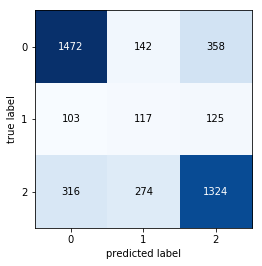

In [14]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(confusion_matrix(yte, ypred))

In [15]:
import numpy as np

feature_names = vect.get_feature_names()

for i, class_label in enumerate(le.classes_):
    top10 = np.argsort(clf.coef_[i])[-20:]
    print("%s: %s" % (class_label, ", ".join(feature_names[j] for j in top10)))
    print()

Junior: woonachtig, met diverse, dan op, leergierig, laptop en, je nog, na een, 2019 tot, leren, starters, 2 jaar, enige, analytische, zojuist, begin, schriftelijke, 1 jaar, 2 500, starter, stage

Medior: stuur je, uiteraard, bij klant, salaris en, needs, hebt affiniteit, onze klant, voorwaarden, 19 solliciteer, haag, om een, beoordelen, bedrijfsgegevens, terecht, mbo opleiding, zullen, circa, jaar relevante, minimaal 3, voor ons

Senior: mei 2019, focus op, begeleidt, een sterke, mogelijk contact, elke dag, gevraagd, elk, een uitstekend, en persoonlijke, je veel, een ervaren, een leaseauto, schrijf, dan direct, je naar, ruime ervaring, 5 10, 10 jaar, minimaal 5

